In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
%matplotlib inline

/Users/DJ/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.11.0
Keras version: 2.1.6-tf


## Define Hyper parameters

In [2]:
learning_rate = 0.01
epochs_value = 5
batch_size_value = 128

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    
    fig, axes = plt.subplots(1, 5)
    fig.subplots_adjust(hspace=1, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28,28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Actual: {0}".format(cls_true[i])
        else:
            xlabel = "Actual: {0},\n Prediction: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## Load Data

In [5]:
#This step uses MNIST.  Next step uses the user created images.
#(nx_train, y_train), (nx_test, y_test) = tf.keras.datasets.mnist.load_data()
#print("Initial Training Dataset: ", y_train.shape, nx_train.shape)
#print("Initial Testing Dataset: ", y_test.shape, nx_test.shape)

Initial Training Dataset:  (60000,) (60000, 28, 28)
Initial Testing Dataset:  (10000,) (10000, 28, 28)


In [6]:
#read image and label arrays
from sklearn.model_selection import train_test_split

X = np.load('images.npy')
y = np.load('labels.npy')

#split data
nx_train, nx_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Initial Training Dataset: ", y_train.shape, nx_train.shape)
print("Initial Testing Dataset: ", y_test.shape, nx_test.shape)

Initial Training Dataset:  (26460,) (26460, 28, 28)
Initial Testing Dataset:  (11340,) (11340, 28, 28)


## Input Data is not normalized

In [22]:
#print(nx_train[0])

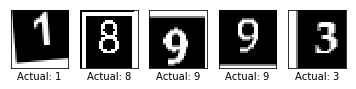

In [7]:
plot_images(nx_train[0:5], y_train[0:5], cls_pred=None)

## Normalize Input Dataset

In [8]:
x_train = nx_train/255
x_test = nx_test/255

In [9]:
# print(x_train[0])

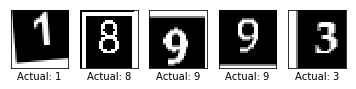

In [10]:
plot_images(x_train[0:5], y_train[0:5], cls_pred=None)

## One hot coding
#### 0 = [1 0 0 0 0 0 0 0 0 0]
#### 1 = [0 1 0 0 0 0 0 0 0 0]
#### ...
#### 9 = [0 0 0 0 0 0 0 0 0 1]

In [11]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## Build CNN using Keras
#### Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

In [12]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total para

In [13]:
layer_input = model.layers[6]
print(layer_input.get_weights()[0].shape)

(256, 10)


In [13]:
#model.save_weights('sim_score_weights.h5', overwrite=True)

## Using Optimization Algorithm for Backpropagation

In [14]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [15]:
print (x_train.shape)
x_train = x_train[..., None]
x_test = x_test[..., np.newaxis]
print (x_train.shape)

(26460, 28, 28)
(26460, 28, 28, 1)


## Training Phase

In [16]:
training_model = model.fit(x_train, y_train, 
                           batch_size=batch_size_value, 
                           epochs=epochs_value,
                           validation_data=(x_test, y_test))

Train on 26460 samples, validate on 11340 samples
Epoch 1/5
26460/26460 [==============================] - 42s 2ms/step - loss: 0.5815 - acc: 0.8180 - val_loss: 0.0754 - val_acc: 0.9809
Epoch 2/5
26460/26460 [==============================] - 42s 2ms/step - loss: 0.0424 - acc: 0.9891 - val_loss: 0.0294 - val_acc: 0.9926
Epoch 3/5
26460/26460 [==============================] - 43s 2ms/step - loss: 0.0154 - acc: 0.9968 - val_loss: 0.0192 - val_acc: 0.9950
Epoch 4/5
26460/26460 [==============================] - 40s 2ms/step - loss: 0.0085 - acc: 0.9980 - val_loss: 0.0069 - val_acc: 0.9983
Epoch 5/5
26460/26460 [==============================] - 40s 2ms/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0139 - val_acc: 0.9951


In [17]:
training_model.history['acc'], training_model.history['val_acc']

([0.817989417989418,
  0.9891156462675139,
  0.9968253968253968,
  0.9979591836734694,
  0.9992819349962208],
 [0.9808641974677905,
  0.9925925925925926,
  0.994973544973545,
  0.9983245149911817,
  0.9951499118165785])

In [18]:
#model.save('model.keras', overwrite=True)
model.save('CNN_999.keras', overwrite=True)

## Evaluation Phase

In [19]:
result = model.evaluate(x_test, y_test)

11340/11340 [==============================] - 4s 381us/step


In [20]:
for name, value in zip(model.metrics_names, result):
    print (name, value)

loss 0.013862203197665447
acc 0.9951499118165785


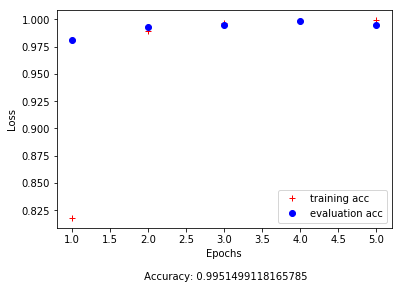

In [21]:
plt.plot(range(1,epochs_value+1), training_model.history['acc'], 'r+', label='training acc')
plt.plot(range(1,epochs_value+1), training_model.history['val_acc'], 'bo', label='evaluation acc')
plt.xlabel('Epochs\n\n Accuracy: '+str(value))
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predication Phase

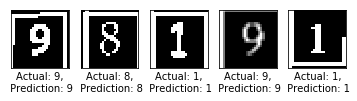

In [22]:
R_img = range (60,65)
plot_images(x_test[R_img], np.argmax(y_test[R_img],axis=1), np.argmax(model.predict(x_test[R_img]), axis=1))

In [23]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [91]:
y_prediction = np.argmax(model.predict(x_test), axis=1)

In [92]:
actual= np.argmax(y_test, axis=1)
len(actual)

10000

In [93]:
misclassification=[i for i in range (10000) if actual[i]!=y_prediction[i]]
len(misclassification)

106

In [94]:
print (len(misclassification))
misclassification

106


[18,
 247,
 321,
 326,
 582,
 646,
 659,
 684,
 720,
 740,
 846,
 924,
 947,
 1014,
 1039,
 1112,
 1226,
 1232,
 1242,
 1260,
 1378,
 1393,
 1414,
 1459,
 1527,
 1709,
 1737,
 1790,
 1878,
 1901,
 1903,
 2035,
 2070,
 2098,
 2118,
 2129,
 2130,
 2182,
 2293,
 2369,
 2414,
 2447,
 2462,
 2488,
 2597,
 2654,
 2896,
 2921,
 2995,
 3073,
 3100,
 3225,
 3384,
 3422,
 3457,
 3520,
 3558,
 3601,
 3662,
 3702,
 3727,
 3778,
 3796,
 3808,
 3853,
 4176,
 4205,
 4238,
 4248,
 4269,
 4497,
 4507,
 4571,
 4639,
 4740,
 4761,
 4763,
 4783,
 5201,
 5331,
 5937,
 5955,
 5981,
 5997,
 6555,
 6576,
 6597,
 6625,
 6755,
 6783,
 8059,
 8094,
 8128,
 8325,
 9015,
 9540,
 9625,
 9642,
 9664,
 9692,
 9729,
 9749,
 9770,
 9792,
 9839,
 9982]

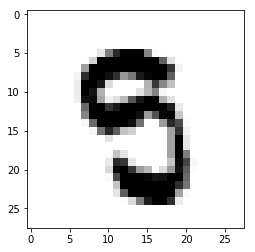

actual:  5 predication:  9


In [96]:
plt.imshow(nx_test[5997].reshape(28,28), cmap='binary')
plt.show()
print("actual: ",actual[5997],"predication: ", y_prediction[5997])